<a href="https://colab.research.google.com/github/juansebastiancalderongarcia/Motor-control-for-speed-transition/blob/main/Sebastian_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torch.optim import Adam
from torch import nn
import numpy as np
from tqdm import tqdm
from google.colab import drive
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace

For all the speeds the dynamics is run over a total time of 2500. That is the reason why all the fast versions of the movement are set to zero in the remaining time

In [ ]:
drive.mount('/mydrive')

Mounted at /mydrive


In [ ]:
cd /mydrive/MyDrive/'Motor control'

/mydrive/MyDrive/Motor control


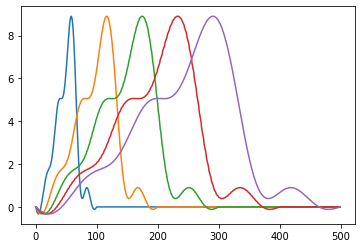

In [ ]:
#Load the muscle activity
muscle_activity = np.load('./muscle_activity.npy')
#Plot the muscle activity
for i in range(muscle_activity.shape[1]):
  plt.plot(muscle_activity[:,i])
plt.show()

In [ ]:
#Load the Wsoc and the initial condition for the dynamics
with open('initial_dynamics.npy', 'rb') as f: 
    Wsoc = np.load(f)
    x0 = np.load(f)

In [ ]:
def sim(X_0,g):
    sol = run_dynamics(W, g, params, X_0)
    X = sol['X'].T 
     
    return torch.tensor(X, dtype=torch.float64).cuda() # [N,T]

def F(X, g_tiled,r_0, r_max):

    '''
    g_tiled - tiled tensor one constant
    '''

    mask = X < 0

    R = torch.empty_like(X).cuda()
    R[mask] = r_0
    R[~mask] = r_max-r_0

    return R * torch.tanh(X*g_tiled*(1./R)).cuda()



In [ ]:
n_iter = 1000
N = Wsoc.shape[0]

T = params['n_time'] #Number of time points
r_0=params['r0'] #Baseline firing rate
r_max=params['rmax'] #Max value for the firing rate

X_0 = x0 #Initial condition [N,1]
W = Wsoc

#The fast version correspons to y0 and the slow one to yf

y_fast = torch.tensor(y0.squeeze(), dtype=torch.float64).cuda() #[N,]
y_slow = torch.tensor(yf.squeeze(), dtype=torch.float64).cuda() #[N,]

# INIT w [N/2,1],b [1], g [N,1]

w = nn.Parameter(torch.randn(N//2,1, dtype=torch.float64).cuda(),  requires_grad=True)
b = nn.Parameter(torch.randn(1, dtype=torch.float64).cuda(), requires_grad=True)
g = nn.Parameter(torch.ones(N, 1, dtype=torch.float64).cuda(), requires_grad=True)
g_tiled = torch.tile(g,(1,T)).cuda()
WBG_params = nn.ParameterList([w, b, g])

opt = Adam(WBG_params.parameters(), lr = 1e-4)

loss_history = []

for i in tqdm_notebook(range(n_iter)):

    # torch.autograd.set_detect_anomaly(True)
    X_fast = sim(X_0, g=np.ones((N,1)))
    X_slow = sim(X_0, g=g.cpu().detach().numpy())

    X_fast_tensor = torch.tensor(X_fast, dtype=torch.float64).cuda() # [N,T]
    X_slow_tensor = torch.tensor(X_slow, dtype=torch.float64).cuda() # [N,T]
    
    F_fast = F(X_fast,g_tiled,r_0, r_max) # [N,T]
    F_slow = F(X_slow,1,r_0, r_max) # [N,T]

    excitatory_mask = W.sum(0) > 0
    F_fast_exc = F_fast[excitatory_mask] # [N/2,T]
    F_slow_exc = F_slow[excitatory_mask] # [N/2,T]

    # w - [N/2,1]
    # b - [1]

    Z_fast_tensor = w.T @ F_fast_exc + b 
    Z_fast_tensor = Z_fast_tensor.flatten() #[T]
    
    Z_slow_tensor = w.T @ F_slow_exc + b
    Z_slow_tensor = Z_slow_tensor.flatten() #[T]

    # y_fast and y_slow - flattened!
    L = torch.norm(y_fast - Z_fast_tensor)**2  + torch.norm(y_slow - Z_slow_tensor)**2 + torch.norm(w)

    L.backward()
    opt.step()

    loss_history.append(L.item())

NameError: ignored

In [ ]:
plt.plot(loss_history)

NameError: ignored

# RNN

$$\tau \frac{dx}{dt} = -x + Wf(x,g)$$

$$\tau \frac{dx}{dt} = -x + Wf(x,g)$$

$$x_{t+1} = x_{t} + \frac{1}{\tau}(-x_{t} + Wf(x_t,g))$$


$$z_t = m^T f(x_t,g) + b$$
<!-- $$ f(x,g) = \  $$ -->

Wsoc shape is:  (400, 400)
x0 shape is:  (1, 400)


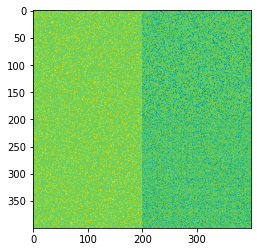

In [ ]:
plt.imshow(Wsoc)
print(f"Wsoc shape is: ", Wsoc.shape)
print(f"x0 shape is: ",(x0.T).shape)

In [ ]:
muscle_activity.shape

(500, 5)

In [ ]:
muscle_activity_tensor = torch.tensor(muscle_activity, dtype=torch.float32).cuda()
print(muscle_activity_tensor.shape)

torch.Size([500, 5])


In [ ]:
class RNNDynamics(nn.Module):
    def __init__(self, 
                 input_dim, # number of neurons * number of conditions
                 output_dim, # z dimension?
                 r_0 = 20,
                 r_max = 100,
                 tau = 200/5): 

        super(RNNDynamics, self).__init__()

        # create connectivity matrix with absolute random values
        self.W = torch.tensor(Wsoc, dtype=torch.float32).cuda()

        # creating g parameters
        # g = gain parameters for the slow version
        # g0 = gain parameters for the fast version constrained to be one

        self.g = nn.Parameter(torch.ones(1,400, 
                                         dtype=torch.float32), 
                              requires_grad=True)
        self.g0 = nn.Parameter(torch.ones(1,400, 
                                         dtype=torch.float32), 
                              requires_grad=False)
        
        # creating tau parameter
        self.tau = tau # 200 accounting for tau and 5 ms for the time-step
        self.r_0 = r_0
        self.r_max = r_max
        self.W_out = nn.Linear(400//2, 
                               1, 
                               bias=True) # `m` and `b` weights

    def f(self, x, g):

        mask = x < 0
        R = torch.empty_like(x).cuda() #[1,N]
        R[mask] = self.r_0
        R[~mask] = self.r_max-self.r_0

        return R * torch.tanh(x*g*(1./R)) #[1,N]

    def forward(self,x_slow, x_fast):

        F_slow = torch.matmul(self.W, self.f(x_slow,self.g).T).T
        F_fast = torch.matmul(self.W, self.f(x_fast,self.g0).T).T 

        # choosing excitatory neurons for the slow version
        excitatory_mask_slow = self.W.sum(0) > 0
        F_exc_slow = F_slow[excitatory_mask_slow.unsqueeze(0)].unsqueeze(0)

        # choosing excitatory neurons for the slow version
        excitatory_mask_fast = self.W.sum(0) > 0
        F_exc_fast = F_fast[excitatory_mask_fast.unsqueeze(0)].unsqueeze(0)

        # W_out already includes m^T and b
        z_current_fast = self.W_out(F_exc_fast)
        x_new_fast = x_fast + (1/self.tau)*(-x_fast + F_fast)

        z_current_slow = self.W_out(F_exc_slow)
        x_new_slow = x_slow + (1/self.tau)*(-x_slow + F_slow)

        return z_current_slow, z_current_fast, x_new_slow, x_new_fast

In [ ]:
N = 400
y_index = -1
n_epochs = 10
T,output_dim = muscle_activity_tensor.shape #[T,1]

rnn_dynamic = RNNDynamics(input_dim=2*N, # number of neurons * 2 conditions
                          output_dim=1*2, # z dimension * 2 conditions
                          r_0=20,
                          r_max=100).cuda()

opt = Adam(rnn_dynamic.parameters(), lr = 1e-3, weight_decay = 1 )

x_slow_seqs = []
z_slow_seqs = []

x_fast_seqs = []
z_fast_seqs = []

losses = []

with torch.autograd.detect_anomaly():
  for ep in tqdm(range(n_epochs)):

    x_slow_seq = []
    z_slow_seq = []

    x_fast_seq = []
    z_fast_seq = []


    # Initial activity
    x_slow = torch.abs(torch.tensor(x0.T, dtype=torch.float32)).cuda()
    x_fast = torch.abs(torch.tensor(x0.T, dtype=torch.float32)).cuda()

    for t in range(T):
        z_current_slow, z_current_fast, x_slow, x_fast = rnn_dynamic(x_slow, x_fast)

        x_slow_seq.append(x_slow)
        z_slow_seq.append(z_current_slow)

        x_fast_seq.append(x_fast)
        z_fast_seq.append(z_current_fast)

    x_slow_seq = torch.cat(x_slow_seq, dim=0)
    x_fast_seq = torch.cat(x_fast_seq, dim=0)

    z_slow_seq = torch.cat(z_slow_seq, dim=0)
    z_fast_seq = torch.cat(z_fast_seq, dim=0)

    loss = torch.pow(torch.norm(z_slow_seq.squeeze() - muscle_activity_tensor[:,-1]), 2) + torch.pow(torch.norm(z_fast_seq.squeeze() - muscle_activity_tensor[:,0]), 2)
    
    opt.zero_grad()
    loss.backward() 
    opt.step()
    losses.append(loss.item())

    x_slow_seqs.append(x_slow_seq.detach().cpu().numpy())
    x_fast_seqs.append(x_fast_seq.detach().cpu().numpy())

    z_slow_seqs.append(z_slow_seq.detach().cpu().numpy())
    z_fast_seqs.append(z_fast_seq.detach().cpu().numpy())

x_slow_seqs = np.array(x_slow_seqs)
z_slow_seqs = np.array(z_slow_seqs)

x_fast_seqs = np.array(x_fast_seqs)
z_fast_seqs = np.array(z_fast_seqs)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
100%|██████████| 10/10 [01:10<00:00,  7.02s/it]


In [ ]:
x_slow_seqs = np.array(x_slow_seqs)
z_slow_seqs = np.array(z_slow_seqs)

x_fast_seqs = np.array(x_fast_seqs)
z_fast_seqs = np.array(z_fast_seqs)

NameError: ignored

In [ ]:
print(x_fast_seqs.shape)
plt.plot(x_fast_seqs[1,:,1])

NameError: ignored

1124566.25


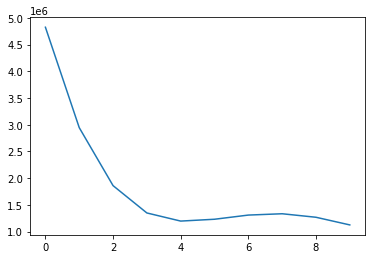

In [ ]:
plt.plot(losses)
print(losses[-1])

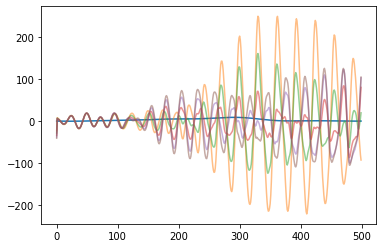

In [ ]:
plt.plot(muscle_activity[:,y_index])
for i in range(0,n_epochs,2):
  plt.plot(z_slow_seqs[i], alpha=0.5)

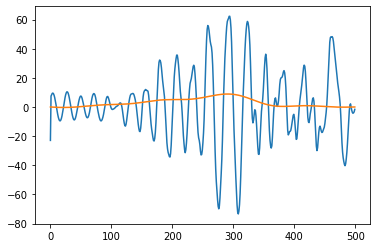

In [ ]:
plt.plot(z_slow_seqs[-1])
plt.plot(muscle_activity_tensor[:,-1].detach().cpu().numpy())

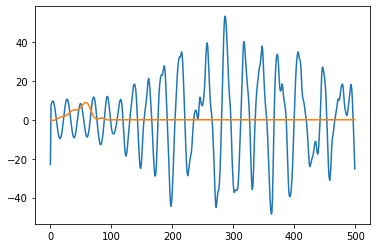

In [ ]:
plt.plot(z_fast_seqs[-1])
plt.plot(muscle_activity_tensor[:,0].detach().cpu().numpy())


In [ ]:
x_slow.shape

torch.Size([1, 400])

NameError: ignored